<a href="https://colab.research.google.com/github/jaydigy/jayg_colab_gate/blob/main/ak_neural_network_from_ak_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ak neural network 강의의 micrograd, velue, neuron, mlp, layer class 코드를 github에서 카피하여 사용함.  youtube 강의 기준 1시간 50분 이후를 체크하기 위함. 

In [1]:
pip install micrograd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [5]:
pip install graphviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from graphviz import Digraph
from micrograd.engine import Value

In [7]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

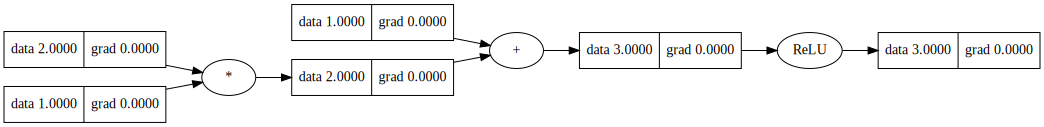

In [8]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
# y.backward()
draw_dot(y)

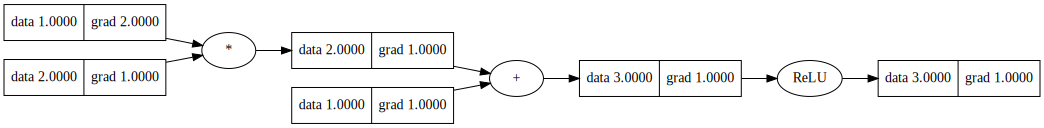

In [9]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

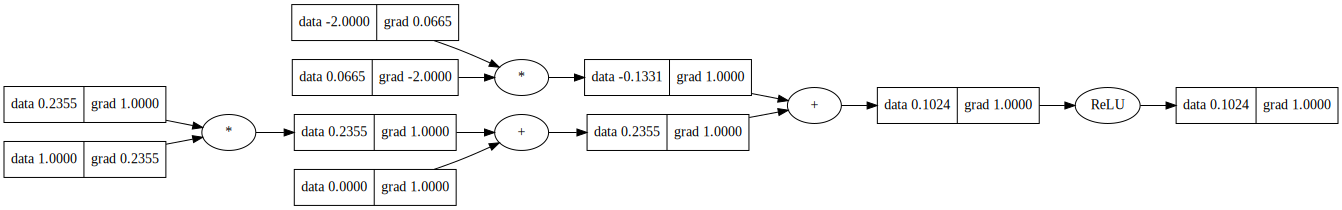

In [10]:
# a simple 2D neuron
import random
from micrograd import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [11]:
import random
from micrograd.engine import Value

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [12]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.17491833012255345, grad=0)

In [13]:
n.parameters()

[Value(data=-0.26830328150124894, grad=0),
 Value(data=0.1715747078045431, grad=0),
 Value(data=-0.6686254326224383, grad=0),
 Value(data=0, grad=0),
 Value(data=0.6487474938152629, grad=0),
 Value(data=-0.23259038277158273, grad=0),
 Value(data=0.5792256498313748, grad=0),
 Value(data=0, grad=0),
 Value(data=0.8434530197925192, grad=0),
 Value(data=-0.3847332240409951, grad=0),
 Value(data=0.9844941451716409, grad=0),
 Value(data=0, grad=0),
 Value(data=-0.5901079958448365, grad=0),
 Value(data=0.31255526637777775, grad=0),
 Value(data=0.8246106857787521, grad=0),
 Value(data=0, grad=0),
 Value(data=-0.7814232047574572, grad=0),
 Value(data=0.6408752595662697, grad=0),
 Value(data=-0.20252189189007108, grad=0),
 Value(data=-0.8693137391598071, grad=0),
 Value(data=0, grad=0),
 Value(data=0.39841666323128555, grad=0),
 Value(data=-0.3037961142013801, grad=0),
 Value(data=-0.19282493884310759, grad=0),
 Value(data=0.6032250931493106, grad=0),
 Value(data=0, grad=0),
 Value(data=0.600130

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired target

ypred = [n(x) for x in xs]
ypred

[Value(data=0.17491833012255345, grad=0),
 Value(data=-1.9336279665121072, grad=0),
 Value(data=-0.42706587737738166, grad=0),
 Value(data=0.15975564404725467, grad=0)]

In [12]:
ypred

[Value(data=-1.7283001384892016, grad=0),
 Value(data=-4.538996946190345, grad=0),
 Value(data=-0.647557196491035, grad=0),
 Value(data=-0.6404440247859625, grad=0)]

In [13]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=22.78339355902601, grad=0)

In [14]:
loss.backward()

In [15]:
n.layers[0].neurons[0].w[0].grad

-5.141561504489178

In [16]:
n.layers[0].neurons[0].w[0].data

0.050238485648542275

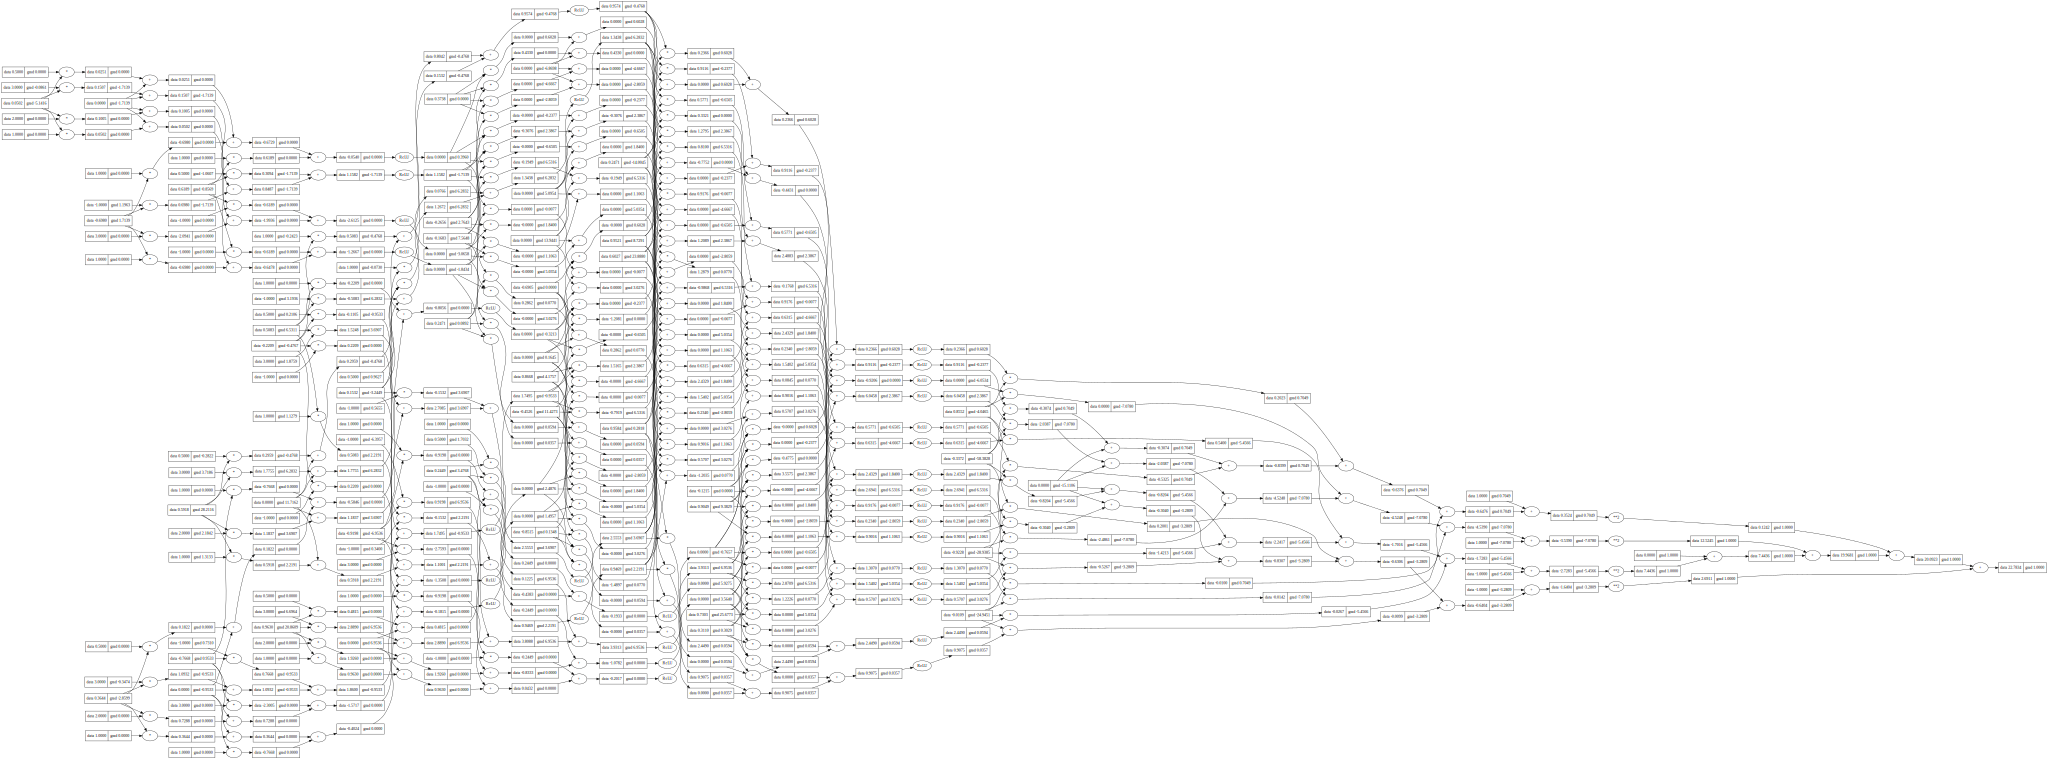

In [17]:
draw_dot(loss)

아래가 학습 순서다 - forward -> backward -> 경사 하강법 update -> pred가 얼마나 타겟에 접근했나 확인 -> 다시 forward 부터 반복

In [48]:
#forward
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.00012328332758100544, grad=0)

In [49]:
#backward
for p in n.parameters():
    p.grad = 0.0
loss.backward()

In [50]:
# 경사하강법 업데이트
for p in n.parameters():
    p.data += -0.01 * p.grad

In [27]:
n.layers[0].neurons[0].w[0].grad

-6.5309170627221595

In [28]:
n.layers[0].neurons[0].w[0].data

0.13533253952844382

In [51]:
ypred

[Value(data=0.9915740356330218, grad=-0.016851928733956356),
 Value(data=-1.0008519702313257, grad=-0.001703940462651321),
 Value(data=-1.0008519702313257, grad=-0.001703940462651321),
 Value(data=0.9928701510873449, grad=-0.014259697825310225)]

아래는 자동으로 학습하는 서머리 코드이며, 처음부터 자동만 실행시키면 ok. 컨펌됨.

In [52]:
for k in range(20):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad


   # print(k, loss.data)



In [53]:
ypred

[Value(data=1.0034274235950675, grad=0.006854847190135072),
 Value(data=-0.9996340991149733, grad=0.0007318017700534973),
 Value(data=-0.9996340991149733, grad=0.0007318017700534973),
 Value(data=1.0030644770989414, grad=0.006128954197882841)]

In [54]:
loss

Value(data=2.140601930528881e-05, grad=1)

요약 :
1. 입력데이터와 출력데이터가 있다. -> 입력데이터의 grad는 의미없음 : 왜냐하면 바뀌지 않기 때문, 신경망을 왔다갔다 하면 w의 값과 grad가 바뀌는 구조임
2. 1차 신경망을 한번 만든다 : w와b가 초기 상태이다. 
3. n(x)로 신경망 값들을 한번 세팅한다. 
4. loss가 정의된다. 
5. loss.backward()를 실행한다. -> w와 grad가 세팅된다. 
6. data값을 학습 rate*grad로 업데이트 해서 옮겨본다. -> 이게 경사하강법임
7. forward로 한번 민다. 
8. grad 값을 0으로 세팅하고 backward로 한번 민다. -> data와 grad 세팅됨
9. loss 값이랑 예측된 ypred를 본다.
10. 6을 실행-> 7 실행 -> 8실행 : 반복
11. 최종적으로 loss값이 거의 0에 가까워지게 되고, ypred가 우리의 타겟 값이다 

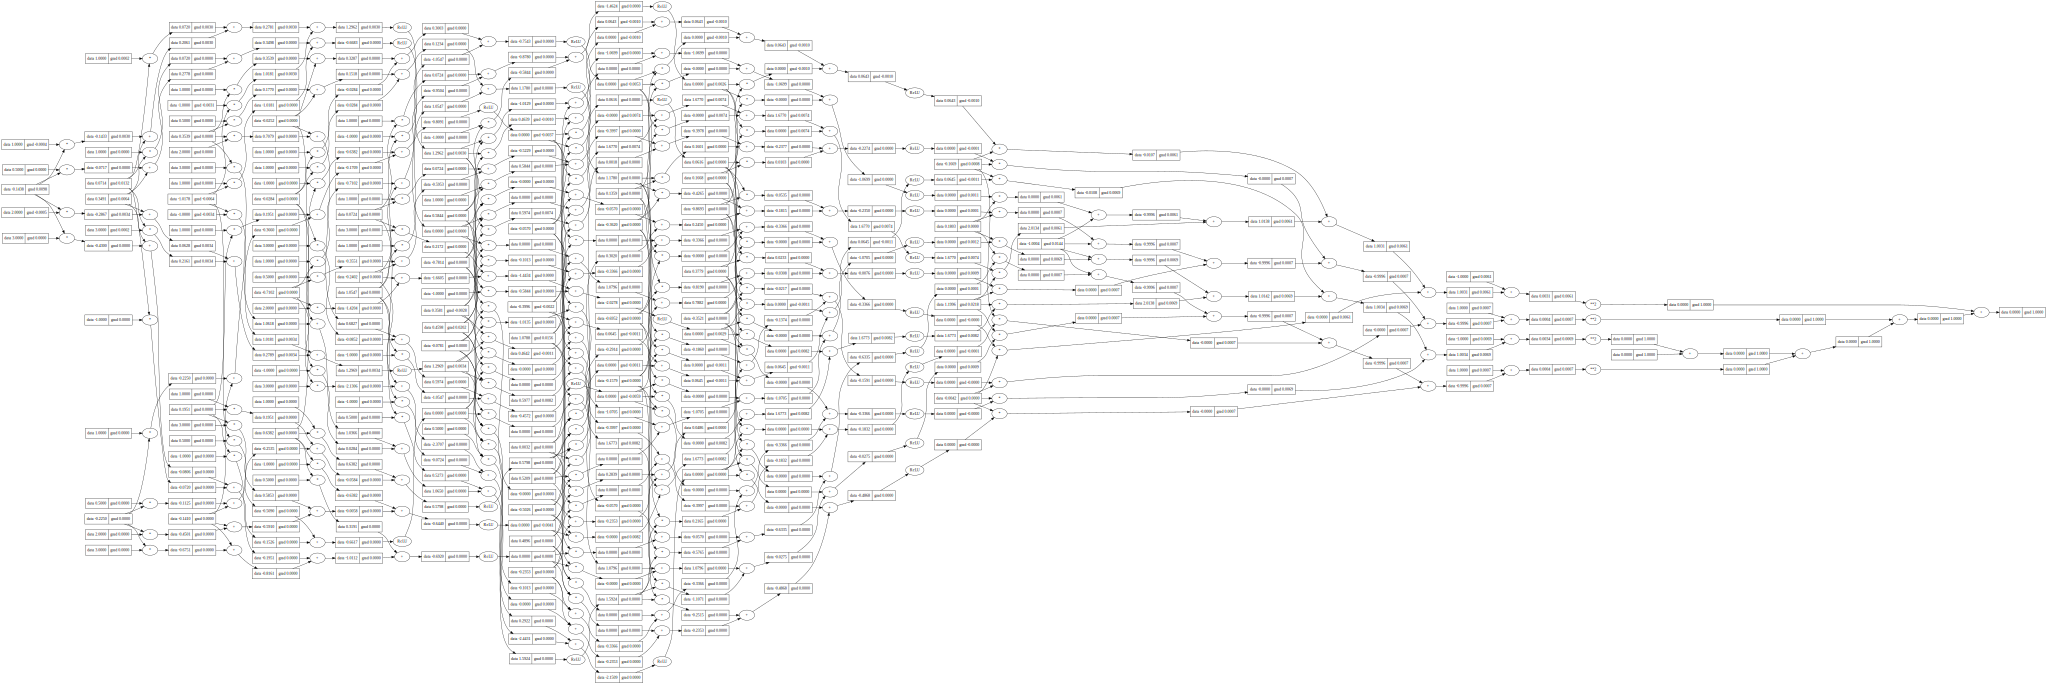

In [55]:
draw_dot(loss)